
Options:
1. Make a prediction
2. Evaluate the model
3. Display feature importance
4. Exit
Amount: 287.13
Use Chip: Online Transaction
Merchant State: Online Transaction
Errors?: No Error
Per Capita Income - Zipcode: 29278
Yearly Income - Person: 59696
Total Debt: 127613
FICO Score: 787
Num Credit Cards: 5
Has Chip: 1
Cards Issued: 2
International: 0
Online: 1
Age_at_transaction: 49
income_to_debt: 0.4677893281422008
day_of_week: 6
time_of_day: Afternoon
distances: 0.0

Prediction: 1
Prediction Probabilities: [0.01068985 0.98931015]

Options:
1. Make a prediction
2. Evaluate the model
3. Display feature importance
4. Exit
Accuracy: 0.9201950757497082
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96   1202369
           1       0.01      0.99      0.03      1266

    accuracy                           0.92   1203635
   macro avg       0.51      0.95      0.49   1203635
weighted avg       1.00      0.92      0.96   

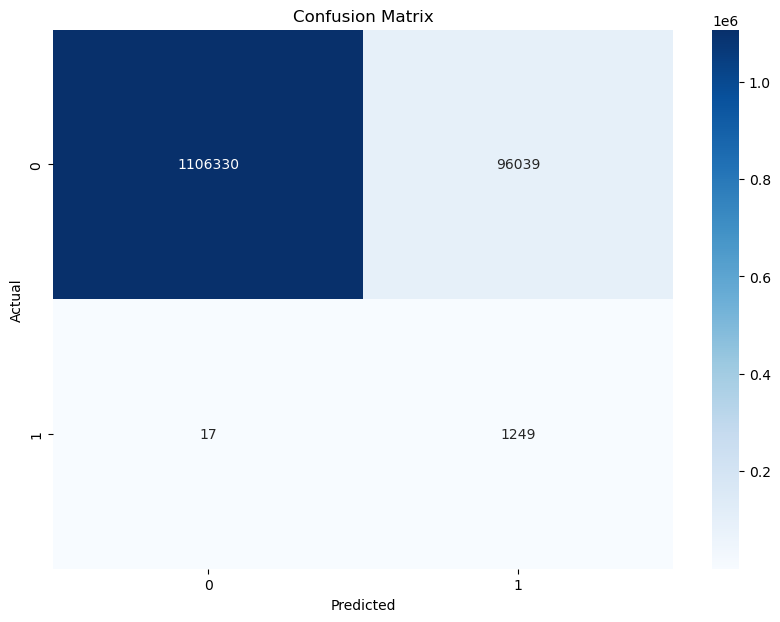


Options:
1. Make a prediction
2. Evaluate the model
3. Display feature importance
4. Exit


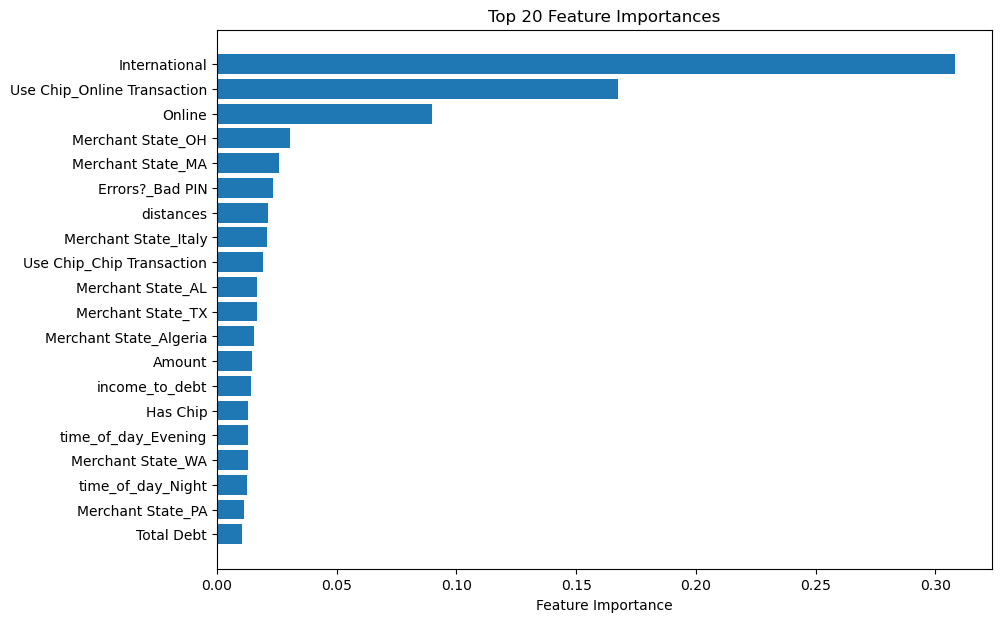


Options:
1. Make a prediction
2. Evaluate the model
3. Display feature importance
4. Exit
Exiting the program.


In [5]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(file_path):
    # Load your DataFrame from a CSV or other source
    df = pd.read_csv(file_path)
    return df

def select_row(df, index):
    try:
        selected_row = df.iloc[[index]]
    except IndexError:
        print(f"Index {index} is out of bounds for the DataFrame.")
        return None
    return selected_row

def predict_row(loaded_model, row):
    # Drop the target column from the selected row
    x = row.drop(columns=["Is Fraud?"])

    # Predict using the loaded model
    prediction = loaded_model.predict(x)
    prediction_proba = loaded_model.predict_proba(x)

    # Create a dictionary from the selected row
    pred_dict = x.iloc[0].to_dict()

    return pred_dict, prediction[0], prediction_proba[0]

def display_prediction(pred_dict, prediction, prediction_proba):
    # Print the dictionary items
    for key, value in pred_dict.items():
        print(f"{key}: {value}")

    # Print the prediction and probabilities
    print(f"\nPrediction: {prediction}")
    print(f"Prediction Probabilities: {prediction_proba}")

def evaluate_model(loaded_model, df):
    X = df.drop(columns=["Is Fraud?"])
    y = df["Is Fraud?"]

    y_pred = loaded_model.predict(X)
    y_pred_proba = loaded_model.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred)
    cm = confusion_matrix(y, y_pred)

    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def get_feature_names(column_transformer):
    """Get feature names from all transformers in the ColumnTransformer"""
    output_features = []

    for name, transformer, features in column_transformer.transformers_:
        if transformer == 'drop':
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            output_features.extend(transformer.get_feature_names_out(features))
        elif hasattr(transformer, 'get_feature_names'):
            output_features.extend(transformer.get_feature_names())
        else:
            output_features.extend(features)

    return output_features

def display_feature_importance(loaded_model, df, top_n=20):
    # If the model is a pipeline, extract the final model and the preprocessor
    if hasattr(loaded_model, 'named_steps'):
        model = loaded_model.named_steps['classifier']
        preprocessor = loaded_model.named_steps['preprocessor']
    else:
        model = loaded_model
        preprocessor = None

    # Get feature names from preprocessor if available
    if preprocessor is not None:
        preprocessor.fit(df.drop(columns=["Is Fraud?"]))  # Ensure the preprocessor is fitted
        feature_names = get_feature_names(preprocessor)
    else:
        feature_names = [f"Feature {i}" for i in range(len(model.feature_importances_))]

    # Check if the model has feature_importances_ attribute
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        
        sorted_idx = np.argsort(feature_importances)[-top_n:]  # Select top_n features
        plt.figure(figsize=(10, 7))
        plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
        plt.xlabel('Feature Importance')
        plt.title(f'Top {top_n} Feature Importances')
        plt.show()
    else:
        print("The model does not have feature_importances_ attribute.")

def main():
    # Load your trained model
    model_path = 'models/trained_model100_xgboost.joblib'
    loaded_model = joblib.load(model_path)

    # Load your data
    data_path = 'data/transactions_users_100.csv'
    df = load_data(data_path)

    while True:
        print("\nOptions:")
        print("1. Make a prediction")
        print("2. Evaluate the model")
        print("3. Display feature importance")
        print("4. Exit")
        choice = input("Enter your choice (1/2/3/4): ")

        if choice == '1':
            # Ask the user for the row index
            try:
                row_index = int(input(f"Enter the row index (0 to {len(df) - 1}) for prediction: "))
            except ValueError:
                print("Invalid input. Please enter a valid integer.")
                continue

            # Select the specified row for prediction
            row = select_row(df, row_index)
            if row is not None:
                # Predict and display the results
                pred_dict, prediction, prediction_proba = predict_row(loaded_model, row)
                display_prediction(pred_dict, prediction, prediction_proba)

        elif choice == '2':
            # Evaluate the model on the entire dataset
            evaluate_model(loaded_model, df)

        elif choice == '3':
            # Display top N feature importance (you can change top_n to the desired number)
            display_feature_importance(loaded_model, df, top_n=20)

        elif choice == '4':
            print("Exiting the program.")
            break

        else:
            print("Invalid choice. Please enter 1, 2, 3, or 4.")

if __name__ == "__main__":
    main()